In [1]:
import sys
import pathlib
pth=str(pathlib.Path().absolute())
sys.path.append(('\\').join(pth.split('\\')[:-1])+"\\Utils")
from Utilities import *
import numpy as np
import skimage
from skimage import io
from skimage import color
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.transform import rotate
from skimage import morphology
import networkx as nx
import json

In [2]:
f1=open(('\\').join(pth.split('\\')[:-2])+"\\Data_base\\validcrop.txt","r")
lines=f1.readlines()
linesn=np.array(lines)
linesn=np.delete(lines,np.where(linesn=="\n"))
linesn=linesn.reshape(-1,3)
#print(linesn[103:])
#linesn=linesn[103:]

linesnc=v_replace_err(linesn)
linesnc=np.vectorize(pyfunc=lambda x:np.array([x[0].split('\n')[0]]),signature="(n)->(m)")(linesnc.reshape(-1,1)).reshape(-1,3)
xywh=linesnc[:,:2]
imgnames=linesnc[:,2]
xywh=v_no_spaces(xywh)
xywh=np.vectorize(pyfunc=(lambda x:float(x)))(xywh.reshape(1,-1)[0])
xywh=xywh.reshape(-1,4).astype(int)+1

dir_origin=('\\').join(pth.split('\\')[:-2])+'\\Data_base\\Imagenes_originales\\'
dir_ROI=('\\').join(pth.split('\\')[:-2])+'\\Data_base\\Sem_Auto\\eye_'
dir_meta=('\\').join(pth.split('\\')[:-2])+'\\Data_base\\Metadata_V7G_sckit\\'

In [15]:
imgnames[40]

'c1anemia-145.jpg'

In [3]:
#40
#name=imgnames[10]
name="c1anemia-101.jpg"
img = io.imread(dir_origin+name)
ROI = io.imread(dir_ROI+name)
mask=assemble_mask(xywh[np.where(imgnames==(name))][0],img,ROI)

In [ ]:
plt.imshow(mark_boundaries(img, slic, mode='inner',background_label=10))

In [ ]:
plt.imshow(ROI)

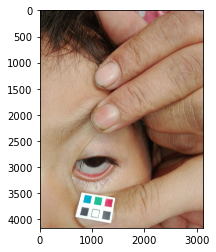

In [5]:
plt.imshow(img)

In [ ]:
wth=100
fmn=np.prod(ROI<wth,axis=2)

fig,((ax1),(ax2))=plt.subplots(2,1,figsize=(30,30))
ax1.imshow(ROI)
ax2.imshow(fmn,cmap="gray")

In [ ]:
wth=200
fmn=np.prod(ROI>wth,axis=2)

fig,((ax1),(ax2))=plt.subplots(2,1,figsize=(35,35))
ax1.imshow(ROI)
ax2.imshow(fmn,cmap="gray")

In [ ]:
wth=200
fmw=np.prod(ROI>wth,axis=2)
wth=100
fmn=np.prod(ROI<wth,axis=2)
fm=np.logical_or(fmn,fmw)

fig,((ax1),(ax2))=plt.subplots(2,1,figsize=(35,35))
ax1.imshow(ROI)
ax2.imshow(fm,cmap="gray")

In [ ]:
wth=200
fmw=np.prod(img>wth,axis=2)
wth=100
fmn=np.prod(img<wth,axis=2)
fm=np.logical_or(fmn,fmw)
slic[np.where(fm)]=35

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(20,20))
ax.imshow(mark_boundaries(img, slic))

In [4]:
SD,G,h,edges=get_graph_from_image(img,mask,desired_nodes=20,angle=90,normalized=True)

E:\Lab_repo\LIIARPI_1\Utils\Utilities.py:426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data=np.array(list(node_features[node].items()))[:,1]


In [12]:
def get_graph_from_image(image,mask,desired_nodes=20,angle=0,normalized=False):
    if normalized:
      SD,segments=get_Normalized_Statistical_Descriptors_(image,mask,n_segments=desired_nodes,angle=angle)
    else:
      SD,segments=get_Statistical_Descriptors_(image,mask,n_segments=desired_nodes,angle=angle)
    nodes=np.array(list(SD))[:]
    node_features=np.vectorize(lambda SD,node:SD[node])(SD,nodes)
    G = nx.Graph()
    for node in nodes[1:]:
        data=np.array(list(node_features[node].items()))[:,1]
        #print(data.shape)
        #print(data)
        afeatures=np.concatenate((np.concatenate(data[:32]),data[32:]))
        #print(afeatures)
        n_features=afeatures.shape[0]
        G.add_node(node-1, features = afeatures)
    
    vs_right = np.vstack([segments[:,:-1].ravel(), segments[:,1:].ravel()])
    vs_below = np.vstack([segments[:-1,:].ravel(), segments[1:,:].ravel()])
    bneighbors = np.unique(np.hstack([vs_right, vs_below]), axis=1)
    bneighbors=np.delete(bneighbors,np.where(bneighbors[1,:]==0),axis=1)
    bneighbors=np.delete(bneighbors,np.where(bneighbors[0,:]==0),axis=1)-1
    
    for i in range(bneighbors.shape[1]):
        if (bneighbors[0,i] != bneighbors[1,i]):
            G.add_edge(bneighbors[0,i],bneighbors[1,i])
    
    for node in nodes[1:]:
        G.add_edge(node-1,node-1)
    
    n = len(G.nodes)
    m = len(G.edges)
    h = np.zeros([n,n_features])
    edges = np.zeros([2*m,2])
    for e,(s,t) in enumerate(G.edges):
        edges[e,0] = s
        edges[e,1] = t
        
        edges[m+e,0] = t
        edges[m+e,1] = s
    for i in G.nodes:
        print(G.nodes[i]["features"])
        h[i,:] = G.nodes[i]["features"]
    return SD,G, h, edges

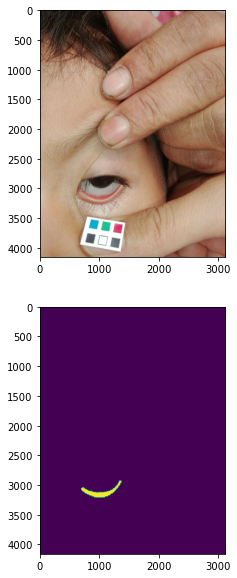

In [24]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,10))
ax1.imshow(img)
lum = np.mean(mask,axis=2).astype(int)
mask=lum>0
ax2.imshow(mask)

In [6]:
imgr=rotate(img,90,resize=True)
maskr=rotate(mask,90,resize=True)

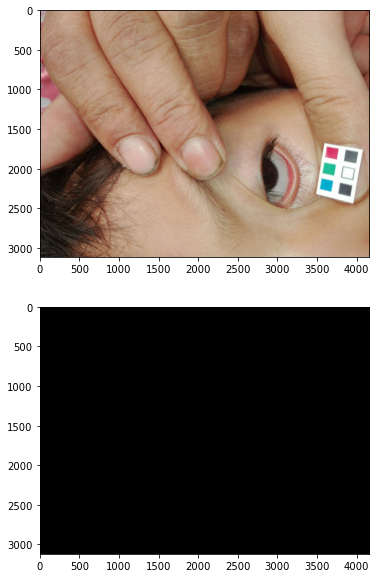

In [8]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,10))
ax1.imshow(imgr)
ax2.imshow(maskr,cmap="gray")

In [29]:
m_slic = slic(image=imgr, n_segments=20,sigma=5,slic_zero=True,mask=maskr)

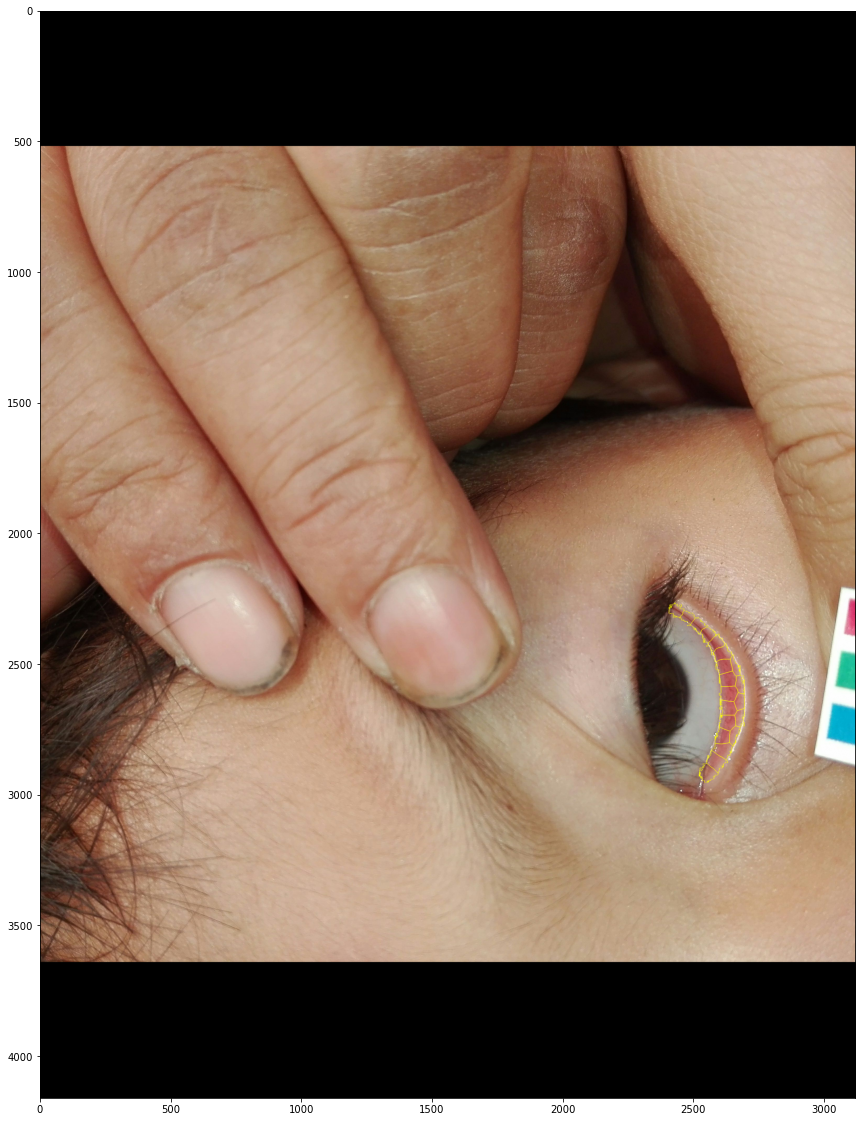

In [31]:
fig,ax=plt.subplots(1,1,figsize=(20,20))
ax.imshow(mark_boundaries(imgr, m_slic))

In [32]:
wth=200
fmw=np.prod(img>wth,axis=2)
wth=100
fmn=np.prod(img<wth,axis=2)
fm=np.logical_or(fmn,fmw)
img=st_adjust(img)

In [5]:
rotate?